In [156]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [284]:
def createDataset():
    # create a dataset
    # X = np.linspace(0, 2*np.pi, 1000)
    X = np.random.uniform(0, 2 * np.pi, 1000)
    Y = np.sin(X) + np.random.normal(0, 0, 1000)
    X = torch.tensor(X, dtype=torch.float32).unsqueeze(1).to(device)
    Y = torch.tensor(Y, dtype=torch.float32).unsqueeze(1).to(device)

    # shuffle the dataset 
    indices = torch.randperm(X.size(0))
    X = X[indices]
    Y = Y[indices]

    return X, Y

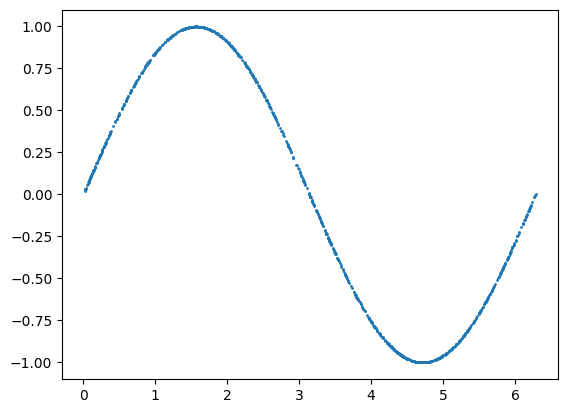

In [285]:
X, Y = createDataset()

plt.scatter(X.cpu().numpy(), Y.cpu().numpy(), s=1)

In [286]:
X_train, Y_train = X[:700], Y[:700]
X_val, Y_val = X[700:800], Y[700:800]
X_test, Y_test = X[800:], Y[800:]

In [293]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, activation=nn.Sigmoid()):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        
        if num_layers < 2:
            raise ValueError("Number of layers must be greater than 1")

        for i in range(num_layers):
            if i == 0:
                self.layers.append(nn.Linear(input_dim, hidden_dim))
            elif i == num_layers - 1:
                self.layers.append(nn.Linear(hidden_dim, output_dim))
            else:
                self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        
        self.activation = activation
    
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        x = self.layers[-1](x)
        return x



def test_model(model, X_val, Y_val):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, Y_val)
    print(f"Validation MSE: {val_loss.item():.2e}")
    return val_loss.item()

# Training function to train the model with given hyperparameters
def train_model(hyper_param, train_loader, X_val, Y_val, MLP):

    if("activation" not in hyper_param):
        hyper_param["activation"] = nn.Sigmoid()
    if("num_layers" not in hyper_param):
        hyper_param["num_layers"] = 2
    if("learning_rate" not in hyper_param):
        hyper_param["learning_rate"] = 0.001
    if("num_epochs" not in hyper_param):
        hyper_param["num_epochs"] = 1000
    

    model = MLP(hyper_param['input_size'], 
                hyper_param['hidden_size'], 
                hyper_param['output_size'],
                hyper_param['num_layers'],
                hyper_param['activation']
                ).to(device)
    
    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=hyper_param['learning_rate'])
    
    # Learning rate scheduler
    if "decay" in hyper_param:
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=hyper_param['decay'])
    elif "final_lr" in hyper_param:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=hyper_param['num_epochs'], eta_min=hyper_param['final_lr'])
    else:
        scheduler = None

    train_losses = []
    val_losses = []
    # Progress bar for the number of epochs
    progress_bar = tqdm(range(hyper_param['num_epochs']), desc="Training progress")
    
    for epoch in progress_bar:
        model.train()  # Set model to training mode

        # Training loop
        for X_batch, Y_batch in train_loader:
            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, Y_batch)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Record the last batch's training loss
        train_losses.append(loss.item())
        
        # Validation step after each epoch
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, Y_val)
            val_losses.append(val_loss.item())
        
        # Update learning rate scheduler
        if scheduler:
            scheduler.step()
        
        # Update progress bar description every epoch with train and validation loss
        if(epoch % 10 == 0):
            progress_bar.set_postfix({"Train Loss": f"{loss.item():.3e}", "Val Loss": f"{val_loss.item():.3e}"})
            progress_bar.update(10)
         
    # Final validation MSE after training
    final_val_loss = test_model(model, X_val, Y_val)

    progress_bar.close()
    return final_val_loss, train_losses, val_losses, model

# Plot function for smoothed losses
def smooth_curve(values, smoothing_factor=0.9):
    smoothed_values = []
    last = values[0]
    for value in values:
        smoothed_value = last * smoothing_factor + (1 - smoothing_factor) * value
        smoothed_values.append(smoothed_value)
        last = smoothed_value
    return smoothed_values
def plot_losses(train_losses, val_losses):
    train_losses_smoothed = smooth_curve(train_losses)
    val_losses_smoothed = smooth_curve(val_losses)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses_smoothed, label="Training Loss (Smoothed)", color="blue")
    plt.plot(val_losses_smoothed, label="Validation Loss (Smoothed)", color="red")
    plt.yscale("log")  # Log scale for the y-axis
    plt.xlabel("Epoch")
    plt.ylabel("Loss (Log Scale)")
    plt.title("Training and Validation Loss (Log Scale with Smoothing)")
    plt.legend()
    plt.show()



In [290]:
dataset = torch.utils.data.TensorDataset(X_train, Y_train)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=True)

In [303]:
# Different configurations for hyperparameters

# Test For Hidden Layer Size

hyper_params_list = [
    {'input_size': 1, 'hidden_size': 32, 'output_size': 1, 'learning_rate': 1e-4, 'num_layers':4, 'num_epochs': 10000},
    {'input_size': 1, 'hidden_size': 64, 'output_size': 1, 'learning_rate': 1e-4, 'num_layers':4, 'num_epochs': 10000},
    {'input_size': 1, 'hidden_size': 128, 'output_size': 1, 'learning_rate': 1e-4, 'num_layers':4, 'num_epochs': 10000},
    {'input_size': 1, 'hidden_size': 256, 'output_size': 1, 'learning_rate': 1e-4, 'num_layers':4, 'num_epochs': 10000},
    {'input_size': 1, 'hidden_size': 512, 'output_size': 1, 'learning_rate': 1e-4, 'num_layers':4, 'num_epochs': 10000},
    # Add more configurations as needed
]

results = []
for idx, hyper_param in enumerate(hyper_params_list):
    print(f"\nTraining with hyperparameters set {idx}: {hyper_param}")
    final_val_loss, train_losses, val_losses, model = train_model(hyper_param, train_loader, X_val, Y_val, MLP)
    results.append((hyper_param, final_val_loss, train_losses, val_losses, model))
    print(f"Final Validation MSE for set {idx}: {final_val_loss}\n")


Training with hyperparameters set 0: {'input_size': 1, 'hidden_size': 32, 'output_size': 1, 'learning_rate': 0.0001, 'num_layers': 4, 'num_epochs': 10000}


Training progress: 100%|██████████| 10000/10000 [01:51<00:00, 89.95it/s, Train Loss=1.418e-07, Val Loss=6.410e-08]


Validation MSE: 8.67e-08
Final Validation MSE for set 0: 8.669682216577712e-08


Training with hyperparameters set 1: {'input_size': 1, 'hidden_size': 64, 'output_size': 1, 'learning_rate': 0.0001, 'num_layers': 4, 'num_epochs': 10000}


Training progress: 100%|██████████| 10000/10000 [01:50<00:00, 90.84it/s, Train Loss=5.914e-09, Val Loss=1.297e-08]


Validation MSE: 3.15e-08
Final Validation MSE for set 1: 3.146359617289818e-08


Training with hyperparameters set 2: {'input_size': 1, 'hidden_size': 128, 'output_size': 1, 'learning_rate': 0.0001, 'num_layers': 4, 'num_epochs': 10000}


Training progress: 100%|██████████| 10000/10000 [01:55<00:00, 86.65it/s, Train Loss=1.016e-07, Val Loss=4.548e-08]


Validation MSE: 1.27e-08
Final Validation MSE for set 2: 1.273572447502147e-08


Training with hyperparameters set 3: {'input_size': 1, 'hidden_size': 256, 'output_size': 1, 'learning_rate': 0.0001, 'num_layers': 4, 'num_epochs': 10000}


Training progress: 100%|██████████| 10000/10000 [01:50<00:00, 90.10it/s, Train Loss=1.012e-05, Val Loss=4.119e-06]


Validation MSE: 2.02e-06
Final Validation MSE for set 3: 2.0243048766133143e-06


Training with hyperparameters set 4: {'input_size': 1, 'hidden_size': 512, 'output_size': 1, 'learning_rate': 0.0001, 'num_layers': 4, 'num_epochs': 10000}


Training progress: 100%|██████████| 10000/10000 [01:48<00:00, 92.53it/s, Train Loss=3.495e-07, Val Loss=1.376e-07]

Validation MSE: 3.98e-06
Final Validation MSE for set 4: 3.98311703975196e-06



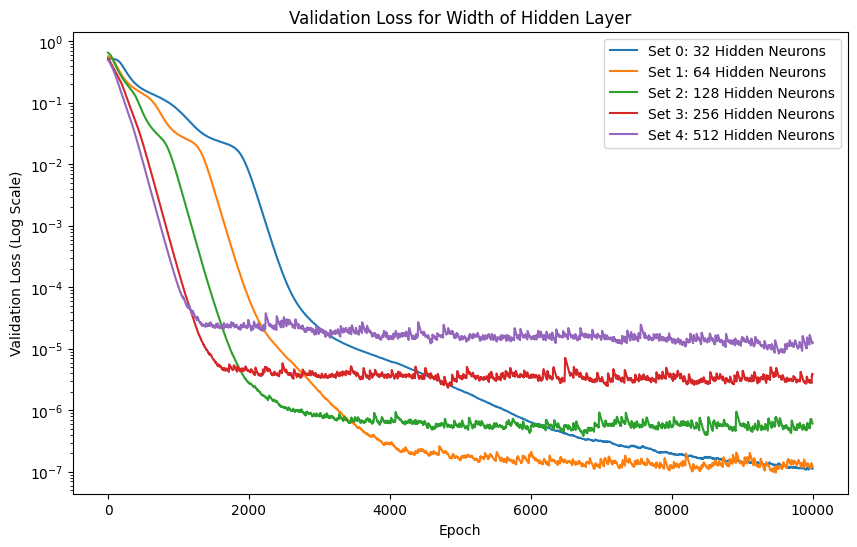

In [304]:
plt.figure(figsize=(10, 6))
for idx, (hyper_param, final_val_loss, train_losses, val_losses, model) in enumerate(results):
    val_losses_smoothed = smooth_curve(val_losses, smoothing_factor=0.99)
    plt.plot(val_losses_smoothed, label=f"Set {idx}: {hyper_param['hidden_size']} Hidden Neurons")
plt.yscale("log")  # Log scale for the y-axis
plt.xlabel("Epoch")
plt.ylabel("Validation Loss (Log Scale)")
plt.title("Validation Loss for Width of Hidden Layer")
plt.legend()
plt.show()

In [297]:
# Different configurations for hyperparameters

# Test For Depth of Network

hyper_params_list = [
    {'input_size': 1, 'hidden_size': 64, 'output_size': 1, 'learning_rate': 0.0001, 'num_layers':2, 'num_epochs': 6000},
    {'input_size': 1, 'hidden_size': 64, 'output_size': 1, 'learning_rate': 0.0001, 'num_layers':3, 'num_epochs': 6000},
    {'input_size': 1, 'hidden_size': 64, 'output_size': 1, 'learning_rate': 0.0001, 'num_layers':4, 'num_epochs': 6000},
    {'input_size': 1, 'hidden_size': 64, 'output_size': 1, 'learning_rate': 0.0001, 'num_layers':5, 'num_epochs': 6000},
    {'input_size': 1, 'hidden_size': 64, 'output_size': 1, 'learning_rate': 0.0001, 'num_layers':6, 'num_epochs': 6000},
]

results = []
for idx, hyper_param in enumerate(hyper_params_list):
    print(f"\nTraining with hyperparameters set {idx}: {hyper_param}")
    final_val_loss, train_losses, val_losses, model = train_model(hyper_param, train_loader, X_val, Y_val, MLP)
    results.append((hyper_param, final_val_loss, train_losses, val_losses, model))
    print(f"Final Validation MSE for set {idx}: {final_val_loss}\n")


Training with hyperparameters set 0: {'input_size': 1, 'hidden_size': 64, 'output_size': 1, 'learning_rate': 0.0001, 'num_layers': 2, 'num_epochs': 6000}


Training progress: 100%|██████████| 6000/6000 [00:56<00:00, 105.87it/s, Train Loss=1.444e-02, Val Loss=1.231e-02]


Validation MSE: 1.22e-02
Final Validation MSE for set 0: 0.012245201505720615


Training with hyperparameters set 1: {'input_size': 1, 'hidden_size': 64, 'output_size': 1, 'learning_rate': 0.0001, 'num_layers': 3, 'num_epochs': 6000}


Training progress: 100%|██████████| 6000/6000 [01:03<00:00, 94.20it/s, Train Loss=1.145e-06, Val Loss=6.617e-07] 


Validation MSE: 7.97e-07
Final Validation MSE for set 1: 7.974050504344632e-07


Training with hyperparameters set 2: {'input_size': 1, 'hidden_size': 64, 'output_size': 1, 'learning_rate': 0.0001, 'num_layers': 4, 'num_epochs': 6000}


Training progress: 100%|██████████| 6000/6000 [01:16<00:00, 78.84it/s, Train Loss=9.163e-08, Val Loss=3.068e-07] 


Validation MSE: 3.35e-08
Final Validation MSE for set 2: 3.349162369659098e-08


Training with hyperparameters set 3: {'input_size': 1, 'hidden_size': 64, 'output_size': 1, 'learning_rate': 0.0001, 'num_layers': 5, 'num_epochs': 6000}


Training progress: 100%|██████████| 6000/6000 [01:26<00:00, 69.63it/s, Train Loss=2.247e-07, Val Loss=6.488e-07]


Validation MSE: 9.56e-08
Final Validation MSE for set 3: 9.564361391767306e-08


Training with hyperparameters set 4: {'input_size': 1, 'hidden_size': 64, 'output_size': 1, 'learning_rate': 0.0001, 'num_layers': 6, 'num_epochs': 6000}


Training progress: 100%|██████████| 6000/6000 [01:21<00:00, 73.58it/s, Train Loss=2.751e-07, Val Loss=6.009e-08]

Validation MSE: 1.65e-07
Final Validation MSE for set 4: 1.650823833188042e-07



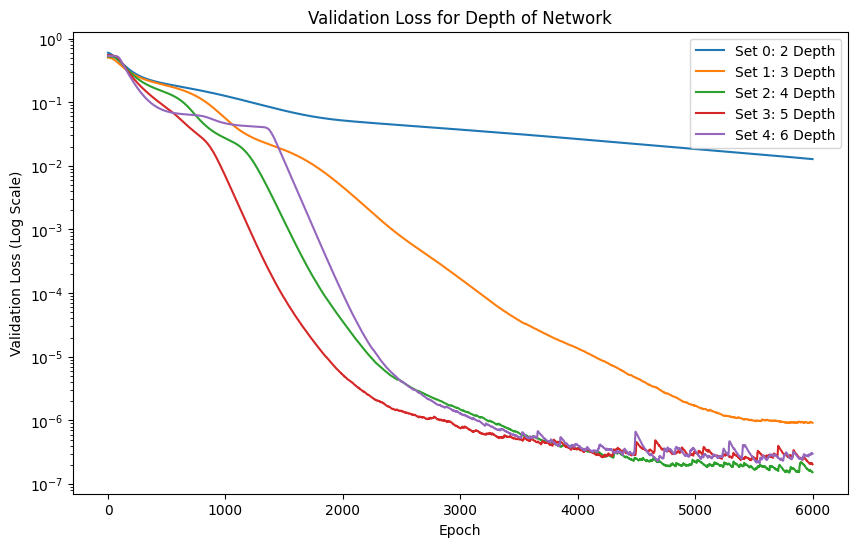

In [298]:
plt.figure(figsize=(10, 6))
for idx, (hyper_param, final_val_loss, train_losses, val_losses, model) in enumerate(results):
    val_losses_smoothed = smooth_curve(val_losses, smoothing_factor=0.99)
    plt.plot(val_losses_smoothed, label=f"Set {idx}: {hyper_param['num_layers']} Depth")
plt.yscale("log")  # Log scale for the y-axis
plt.xlabel("Epoch")
plt.ylabel("Validation Loss (Log Scale)")
plt.title("Validation Loss for Depth of Network")
plt.legend()
plt.show()

In [299]:
# Different configurations for hyperparameters

# Test For different activation functions

hyper_params_list = [
    {'input_size': 1, 'hidden_size': 64, 'output_size': 1, 'learning_rate': 0.0001, 'num_layers':4, 'num_epochs': 6000, 'activation': nn.Sigmoid()},
    {'input_size': 1, 'hidden_size': 64, 'output_size': 1, 'learning_rate': 0.0001, 'num_layers':4, 'num_epochs': 6000, 'activation': nn.ReLU()},
    {'input_size': 1, 'hidden_size': 64, 'output_size': 1, 'learning_rate': 0.0001, 'num_layers':4, 'num_epochs': 6000, 'activation': nn.Tanh()},
    {'input_size': 1, 'hidden_size': 64, 'output_size': 1, 'learning_rate': 0.0001, 'num_layers':4, 'num_epochs': 6000, 'activation': nn.LeakyReLU()},
]

results = []
for idx, hyper_param in enumerate(hyper_params_list):
    print(f"\nTraining with hyperparameters set {idx}: {hyper_param}")
    final_val_loss, train_losses, val_losses, model = train_model(hyper_param, train_loader, X_val, Y_val, MLP)
    results.append((hyper_param, final_val_loss, train_losses, val_losses, model))
    print(f"Final Validation MSE for set {idx}: {final_val_loss}\n")


Training with hyperparameters set 0: {'input_size': 1, 'hidden_size': 64, 'output_size': 1, 'learning_rate': 0.0001, 'num_layers': 4, 'num_epochs': 6000, 'activation': Sigmoid()}


Training progress: 100%|██████████| 6000/6000 [01:09<00:00, 86.57it/s, Train Loss=2.132e-08, Val Loss=2.607e-08] 


Validation MSE: 2.85e-08
Final Validation MSE for set 0: 2.853232317079346e-08


Training with hyperparameters set 1: {'input_size': 1, 'hidden_size': 64, 'output_size': 1, 'learning_rate': 0.0001, 'num_layers': 4, 'num_epochs': 6000, 'activation': ReLU()}


Training progress: 100%|██████████| 6000/6000 [01:17<00:00, 77.48it/s, Train Loss=4.434e-07, Val Loss=1.374e-07] 


Validation MSE: 1.74e-07
Final Validation MSE for set 1: 1.74054605395213e-07


Training with hyperparameters set 2: {'input_size': 1, 'hidden_size': 64, 'output_size': 1, 'learning_rate': 0.0001, 'num_layers': 4, 'num_epochs': 6000, 'activation': Tanh()}


Training progress: 100%|██████████| 6000/6000 [01:22<00:00, 72.42it/s, Train Loss=8.035e-07, Val Loss=2.315e-06] 


Validation MSE: 1.70e-06
Final Validation MSE for set 2: 1.69921952419827e-06


Training with hyperparameters set 3: {'input_size': 1, 'hidden_size': 64, 'output_size': 1, 'learning_rate': 0.0001, 'num_layers': 4, 'num_epochs': 6000, 'activation': LeakyReLU(negative_slope=0.01)}


Training progress: 100%|██████████| 6000/6000 [01:15<00:00, 79.58it/s, Train Loss=4.838e-06, Val Loss=1.768e-05] 

Validation MSE: 3.52e-06
Final Validation MSE for set 3: 3.51957146449422e-06



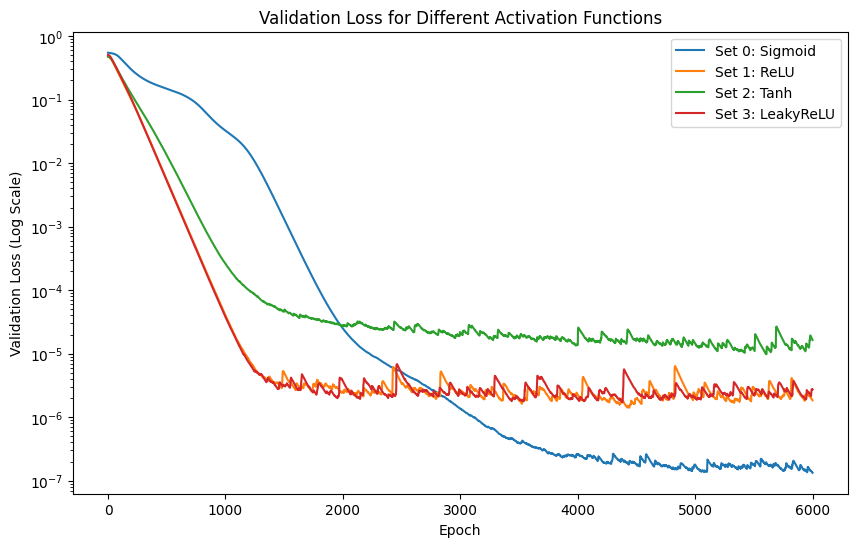

In [300]:
plt.figure(figsize=(10, 6))
for idx, (hyper_param, final_val_loss, train_losses, val_losses, model) in enumerate(results):
    val_losses_smoothed = smooth_curve(val_losses, smoothing_factor=0.99)

    name = hyper_param['activation'].__class__.__name__

    plt.plot(val_losses_smoothed, label=f"Set {idx}: {name}")
plt.yscale("log")  # Log scale for the y-axis
plt.xlabel("Epoch")
plt.ylabel("Validation Loss (Log Scale)")
plt.title("Validation Loss for Different Activation Functions")
plt.legend()
plt.show()

In [305]:
# Different configurations for hyperparameters

# Test For Learning Rate

hyper_params_list = [
    {'input_size': 1, 'hidden_size': 64, 'output_size': 1, 'learning_rate': 0.1, 'num_layers':4, 'num_epochs': 15000},
    {'input_size': 1, 'hidden_size': 64, 'output_size': 1, 'learning_rate': 0.01, 'num_layers':4, 'num_epochs': 15000},
    {'input_size': 1, 'hidden_size': 64, 'output_size': 1, 'learning_rate': 0.001, 'num_layers':4, 'num_epochs': 15000},
    {'input_size': 1, 'hidden_size': 64, 'output_size': 1, 'learning_rate': 0.0001, 'num_layers':4, 'num_epochs': 15000},
    {'input_size': 1, 'hidden_size': 64, 'output_size': 1, 'learning_rate': 0.00001, 'num_layers':4, 'num_epochs': 15000},
]

results = []
for idx, hyper_param in enumerate(hyper_params_list):
    print(f"\nTraining with hyperparameters set {idx}: {hyper_param}")
    final_val_loss, train_losses, val_losses, model = train_model(hyper_param, train_loader, X_val, Y_val, MLP)
    results.append((hyper_param, final_val_loss, train_losses, val_losses, model))
    print(f"Final Validation MSE for set {idx}: {final_val_loss}\n")


Training with hyperparameters set 0: {'input_size': 1, 'hidden_size': 64, 'output_size': 1, 'learning_rate': 0.1, 'num_layers': 4, 'num_epochs': 15000}


Training progress: 100%|██████████| 15000/15000 [02:45<00:00, 90.55it/s, Train Loss=2.563e-02, Val Loss=3.990e-02] 


Validation MSE: 4.01e-02
Final Validation MSE for set 0: 0.040078628808259964


Training with hyperparameters set 1: {'input_size': 1, 'hidden_size': 64, 'output_size': 1, 'learning_rate': 0.01, 'num_layers': 4, 'num_epochs': 15000}


Training progress: 100%|██████████| 15000/15000 [02:44<00:00, 90.92it/s, Train Loss=1.934e-04, Val Loss=2.716e-04] 


Validation MSE: 9.49e-06
Final Validation MSE for set 1: 9.488579962635413e-06


Training with hyperparameters set 2: {'input_size': 1, 'hidden_size': 64, 'output_size': 1, 'learning_rate': 0.001, 'num_layers': 4, 'num_epochs': 15000}


Training progress: 100%|██████████| 15000/15000 [02:45<00:00, 90.84it/s, Train Loss=1.957e-07, Val Loss=3.835e-07] 


Validation MSE: 1.09e-07
Final Validation MSE for set 2: 1.0869317179640348e-07


Training with hyperparameters set 3: {'input_size': 1, 'hidden_size': 64, 'output_size': 1, 'learning_rate': 0.0001, 'num_layers': 4, 'num_epochs': 15000}


Training progress: 100%|██████████| 15000/15000 [02:47<00:00, 89.45it/s, Train Loss=1.629e-08, Val Loss=8.038e-09] 


Validation MSE: 5.39e-07
Final Validation MSE for set 3: 5.386086741054896e-07


Training with hyperparameters set 4: {'input_size': 1, 'hidden_size': 64, 'output_size': 1, 'learning_rate': 1e-05, 'num_layers': 4, 'num_epochs': 15000}


Training progress: 100%|██████████| 15000/15000 [02:57<00:00, 84.59it/s, Train Loss=1.501e-05, Val Loss=5.494e-06] 

Validation MSE: 5.57e-06
Final Validation MSE for set 4: 5.569362201640615e-06



In [306]:
final_ir = 1e-6
init_rate = 1e-2
epochs = 15000
gamma = (final_ir / init_rate) ** (1 / epochs)

hyper_param = {'input_size': 1, 'hidden_size': 64, 'output_size': 1, 'learning_rate': init_rate, 'num_layers':4, 'num_epochs': epochs, 'decay': gamma}
final_val_loss, train_losses, val_losses, model = train_model(hyper_param, train_loader, X_val, Y_val, MLP)
results.append((hyper_param, final_val_loss, train_losses, val_losses, model))

Training progress: 100%|██████████| 15000/15000 [02:54<00:00, 85.91it/s, Train Loss=3.384e-08, Val Loss=1.429e-08] 

Validation MSE: 1.35e-08


In [307]:
final_ir = 1e-9
init_rate = 1e-4
epochs = 15000

hyper_param = {'input_size': 1, 'hidden_size': 64, 'output_size': 1, 'learning_rate': init_rate, 'num_layers':4, 'num_epochs': epochs, 'final_lr': final_ir}
final_val_loss, train_losses, val_losses, model = train_model(hyper_param, train_loader, X_val, Y_val, MLP)
results.append((hyper_param, final_val_loss, train_losses, val_losses, model))

Training progress: 100%|██████████| 15000/15000 [03:03<00:00, 81.92it/s, Train Loss=1.429e-08, Val Loss=1.358e-08] 

Validation MSE: 1.36e-08


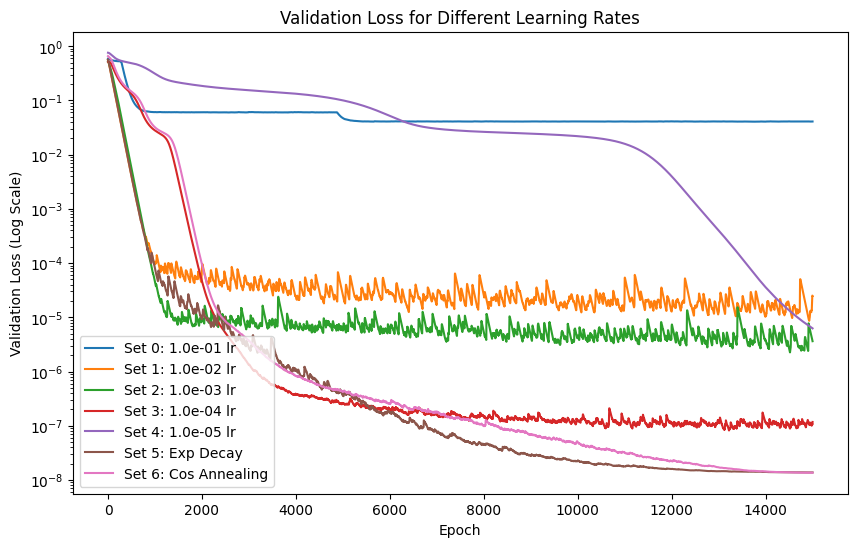

In [310]:
plt.figure(figsize=(10, 6))
for idx, (hyper_param, final_val_loss, train_losses, val_losses, model) in enumerate(results):
    val_losses_smoothed = smooth_curve(val_losses, smoothing_factor=0.99)
    if("final_lr" in hyper_param):
        plt.plot(val_losses_smoothed, label=f"Set {idx}: Cos Annealing")
    elif("decay" in hyper_param):
        plt.plot(val_losses_smoothed, label=f"Set {idx}: Exp Decay")
    else:
        plt.plot(val_losses_smoothed, label=f"Set {idx}: {hyper_param['learning_rate']:.1e} lr")
plt.yscale("log")  # Log scale for the y-axis
plt.xlabel("Epoch")
plt.ylabel("Validation Loss (Log Scale)")
plt.title("Validation Loss for Different Learning Rates")
plt.legend()
plt.show()

In [324]:
best_result = results[5]

In [325]:
hyper_param, final_val_loss, train_losses, val_losses, model = best_result
hyper_param

{'input_size': 1,
 'hidden_size': 64,
 'output_size': 1,
 'learning_rate': 0.01,
 'num_layers': 4,
 'num_epochs': 15000,
 'decay': 0.9993861657818901,
 'activation': Sigmoid()}

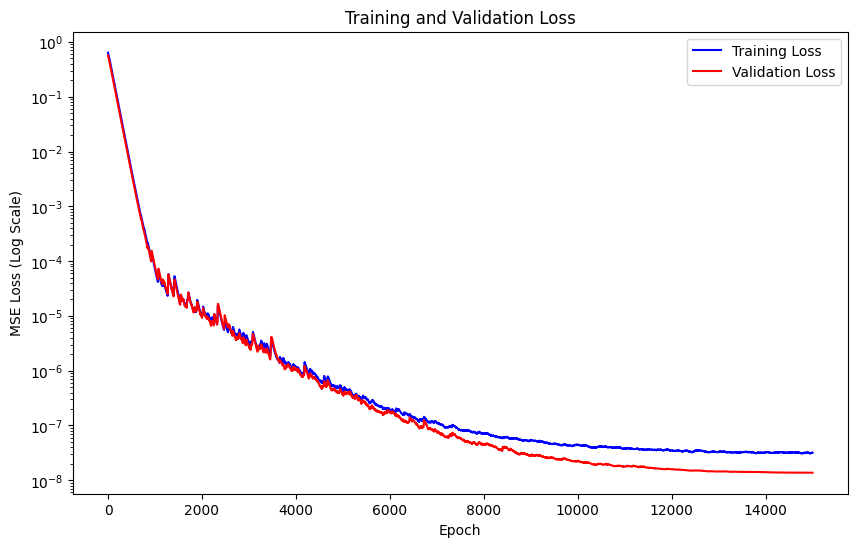

In [327]:
train_losses_smoothed = smooth_curve(train_losses, smoothing_factor=0.99)
val_losses_smoothed = smooth_curve(val_losses, smoothing_factor=0.99)

plt.figure(figsize=(10, 6))
plt.plot(train_losses_smoothed, label="Training Loss", color="blue")
plt.plot(val_losses_smoothed, label="Validation Loss", color="red")
plt.yscale("log")  # Log scale for the y-axis
plt.xlabel("Epoch")
plt.ylabel("MSE Loss (Log Scale)")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()


In [315]:
test_loss = test_model(model, X_test, Y_test)
print(f"Test MSE: {test_loss:.2e}")

Validation MSE: 1.70e-08
Test MSE: 1.70e-08


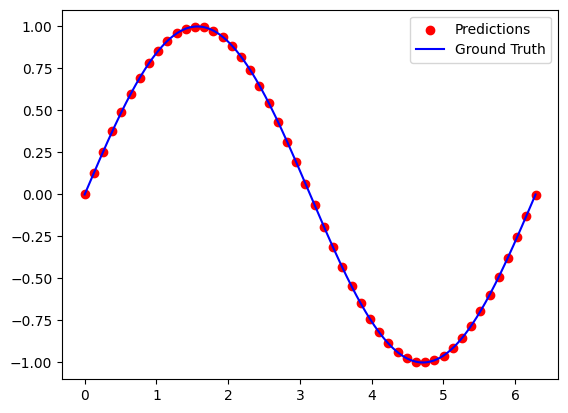

In [323]:
new_x = torch.linspace(0, 2*np.pi, 50).unsqueeze(1).to(device)
new_y = model(new_x).detach().cpu()

new_x = new_x.cpu().numpy()

ref_x = np.linspace(0, 2*np.pi, 1000)
ref_y = np.sin(ref_x)

plt.scatter(new_x, new_y, color='red', label='Predictions')
plt.plot(ref_x, ref_y, color='blue', label='Ground Truth')
plt.legend()
plt.show()